In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
from imblearn.over_sampling import RandomOverSampler

2024-09-10 08:03:44.498036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load preprocess image data
train_images = np.load('../data/processed/train_images.npy')
train_labels = np.load('../data/processed/train_labels.npy')
val_images = np.load('../data/processed/val_images.npy')
val_labels = np.load('../data/processed/val_labels.npy')
test_images = np.load('../data/processed/test_images.npy')
test_labels = np.load('../data/processed/test_labels.npy')

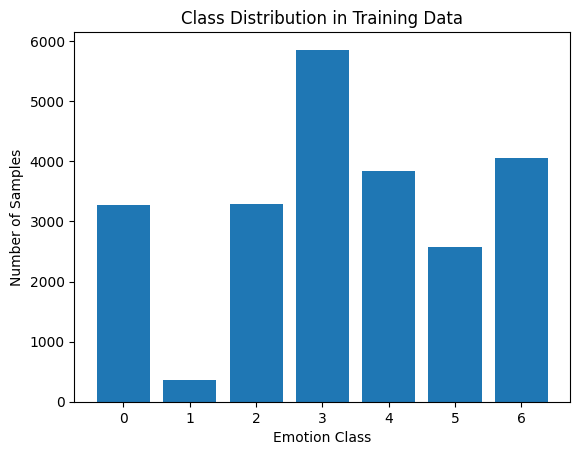

In [3]:
# Count the number of samples per class
class_counts = Counter(train_labels)

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.show()

In [4]:
# Oversample minority classes
ros = RandomOverSampler()
train_images_resampled, train_labels_resampled = ros.fit_resample(train_images.reshape(-1, 48 * 48), train_labels)
train_images_resampled = train_images_resampled.reshape(-1, 48, 48, 1)

### Model Building and Training

In [5]:
def build_model():
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second Conv Block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third Conv Block
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Fourth Conv Block
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten Layer to transform the 2D feature maps to 1D vector
        #Flatten(),
        GlobalAveragePooling2D(),

        # Fully Connected Layer
        Dense(1024, activation='relu'),
        #Dropout(0.5),
        #Dropout(0.2),

        # Output Layer with 7 emotion categories
        Dense(7, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(train_images, train_labels, val_images, val_labels):
    model = build_model()
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Define class weights to balance the dataset
    '''class_weights = {
        0: 1.3,  # Angry
        1: 1.5,  # Disgust
        2: 1.4,  # Fear
        3: 0.7,  # Happy
        4: 1.3,  # Sad
        5: 1.0,  # Surprise
        6: 1.2   # Neutral
    }'''

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    train_generator = datagen.flow(train_images_resampled, train_labels_resampled, batch_size=64)
    history = model.fit(train_generator, epochs=20, callbacks=[early_stopping], validation_data=(val_images, val_labels))
    
    # Save the model
    model.save('../models/facial_emotion_model.keras')
    
    return history

# Prepare data
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)

# Train model
history = train_model(train_images, train_labels, val_images, val_labels)

Epoch 1/20
641/641 [==============================] - 123s 190ms/step - loss: 1.7988 - accuracy: 0.2867 - val_loss: 1.8243 - val_accuracy: 0.2786
Epoch 2/20
641/641 [==============================] - 120s 187ms/step - loss: 1.4569 - accuracy: 0.4426 - val_loss: 1.3174 - val_accuracy: 0.4930
Epoch 3/20
641/641 [==============================] - 150s 235ms/step - loss: 1.3057 - accuracy: 0.5067 - val_loss: 1.3093 - val_accuracy: 0.4930
Epoch 4/20
641/641 [==============================] - 176s 274ms/step - loss: 1.2184 - accuracy: 0.5385 - val_loss: 1.2045 - val_accuracy: 0.5399
Epoch 5/20
641/641 [==============================] - 121s 189ms/step - loss: 1.1524 - accuracy: 0.5642 - val_loss: 1.2433 - val_accuracy: 0.5259
Epoch 6/20
641/641 [==============================] - 121s 189ms/step - loss: 1.1062 - accuracy: 0.5816 - val_loss: 1.2320 - val_accuracy: 0.5352
Epoch 7/20
641/641 [==============================] - 610s 953ms/step - loss: 1.0599 - accuracy: 0.6041 - val_loss: 1.1997 -

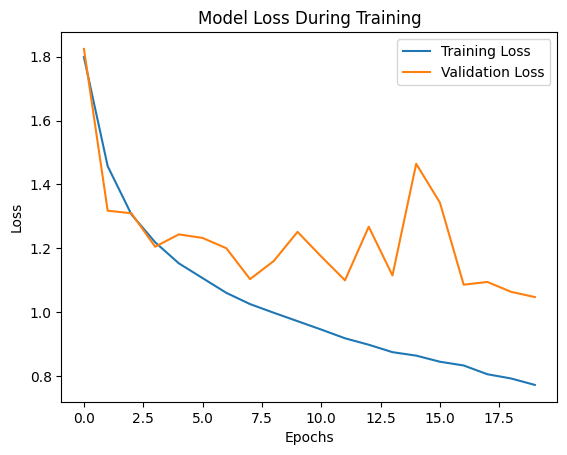

In [12]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Displaying legend
plt.legend(loc='upper right')

#plt.savefig('../plots/model_loss_during_training.png')

# Show the plot
plt.show()